## Data processing
The competition provides three files: 
* `train.csv`: personal records for about two-thirds (~8700) of the passengers, to be used as training data
* `test.csv`: personal records for the remaining one-third (~4300) of the passengers, to be used as test data
* `sample_submission`: a submission file in the correct format
Which are all located in the `data/` directory.

Our first task is to load and preprocess the data to be able to feed it into our neural network for training. As we can see, there's lots of non-numerical data.
We are going to perform feature encoding for each of the columns containing non-numerical data, and some feature engineering after that to (potentially) improve the model's performance. 

### First things first
Importing libraries. Make sure you have them installed (check the instructions in the `README.md`)

In [1]:
import re
import random
from statistics import mean
from collections import Counter
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report

IS_TRAIN = False


# Load training and test data
base_file_path = "./data/"
test_data = pd.read_csv(base_file_path+'test.csv')
training_data = pd.read_csv(base_file_path+('train.csv' if IS_TRAIN else 'test.csv'))
print(training_data.columns)

pd.set_option('future.no_silent_downcasting', True)

Index(['PassengerId', 'HomePlanet', 'CryoSleep', 'Cabin', 'Destination', 'Age',
       'VIP', 'RoomService', 'FoodCourt', 'ShoppingMall', 'Spa', 'VRDeck',
       'Name'],
      dtype='object')


### Turning planets into numbers
We will turn the `HomePlanet` and `Destination` columns into numeric values representing each planet

In [2]:
# Drop the "Name" column - we won't be using that data to train the model
training_data = training_data.drop('Name', axis=1)

# Load the 'HomePlanet' and'"Destination' columns
home_planets = training_data.get('HomePlanet').unique().tolist()[:-1]
destinations = training_data.get('Destination').unique().tolist()[:-1]

# Convert both columns to a dictionary 
home_planets_map = {k: v for v, k in enumerate(home_planets)}
destinations_map = {k: v for v, k in enumerate(destinations)}

# Turn both columns into their respective keys in the dictionary
training_data['HomePlanet'] = training_data['HomePlanet'].replace(home_planets_map)
training_data['Destination'] = training_data['Destination'].replace(destinations_map)

# Mark them as numeric
training_data['HomePlanet'] = pd.to_numeric(training_data['HomePlanet'], errors='coerce')
training_data['Destination'] = pd.to_numeric(training_data['Destination'], errors='coerce')

### Cabin IDs are a problem
Cabin IDs are structured as follows: "letter/number/letter" (i.e B/0/P).

We need to:
- encode them
- replace missing values in a non-random way

The number in the middle seems to be increasing non-monotonically, so I decided to replace missing values for a random number in the following range: $|(\text{prev valid value} - 5, \text{prev valid value})|$.

For the letters, it's clear that they repeat, so I decided to we create probability mappings and replace missing letters based on those.

In [3]:

# Get the 'Cabin' column, whose values are formatted as 'letter/number/letter'
cabins = training_data.get('Cabin')

# Separate 'Cabin' into 'Cabin_N' with N \in {1,2,3}
pattern = re.compile(r'^([a-zA-Z])/(\d+)/([a-zA-Z])$')

parsed_cabins = [
    (matches.group(1), int(matches.group(2)), matches.group(3)) if (matches := pattern.match(str(cabin)))
    else ('NA', -1, 'NA')
    for cabin in cabins
]

# Transpose the parsed_cabins to separate lists for cabin_1, cabin_2, and cabin_3
cabin_1, cabin_2, cabin_3 = map(list, zip(*parsed_cabins))

# Replace missing numbers for a random value in |(previous valid value - 5, previous valid value)| 
# just because it seems to work
prev_valid_val = None
cabin_2 = [abs(random.randint(prev_valid_val-10, prev_valid_val)) if x == -1 else (prev_valid_val := x) for x in cabin_2]


# Methods to compute probabilities for letter in the cabin IDs
def list_to_probability_mapping(value_list):
    value_counts = Counter(value_list)
    total_count = len(value_list)

    probability_mapping = {value: count / total_count for value, count in value_counts.items()}

    return probability_mapping

def get_index_from_probability_mapping(probability_mapping):
    indices = list(range(len(probability_mapping)))
    probabilities = list(probability_mapping.values())
    return np.random.choice(indices, p=probabilities)

def get_mean_val_randomized(dictionary):
  return int(np.random.normal(loc=mean(dictionary), scale=2))

# Create probability mappings
cabin_1_map = list_to_probability_mapping(cabin_1)
cabin_3_map = list_to_probability_mapping(cabin_3)

# Replace missing letters for another value, weighing probability
cabin_1 = [get_index_from_probability_mapping(cabin_1_map) if x == 'NA' else x for x in cabin_1]
cabin_3 = [get_index_from_probability_mapping(cabin_3_map) if x == 'NA' else x for x in cabin_3]

# Replace the 'Cabin' column for 'Cabin_ID_1, Cabin_ID_2, Cabin_ID_3' with their respective values
training_data = training_data.drop('Cabin', axis=1)
training_data['Cabin_ID_1'] = cabin_1
training_data['Cabin_ID_2'] = cabin_2
training_data['Cabin_ID_3'] = cabin_3

### Turning booleans into numbers is easier
The "CryoSleep", "VIP" and "Transported" columns can be turned into numbers trivially.

In [4]:
training_data['CryoSleep'] = np.where(training_data['CryoSleep'] == True, 1, 0)
training_data['VIP'] = np.where(training_data['VIP'] == True, 1, 0)

if IS_TRAIN:
    training_data['Transported'] = np.where(training_data['Transported'] == True, 1, 0)

### What are CabinIDs, tho?
We plot a heatmap to visualize the value distribution and correlation between the Cabin_ID_1 and Cabin_ID_3 values. We also check the cardinality of each variable.

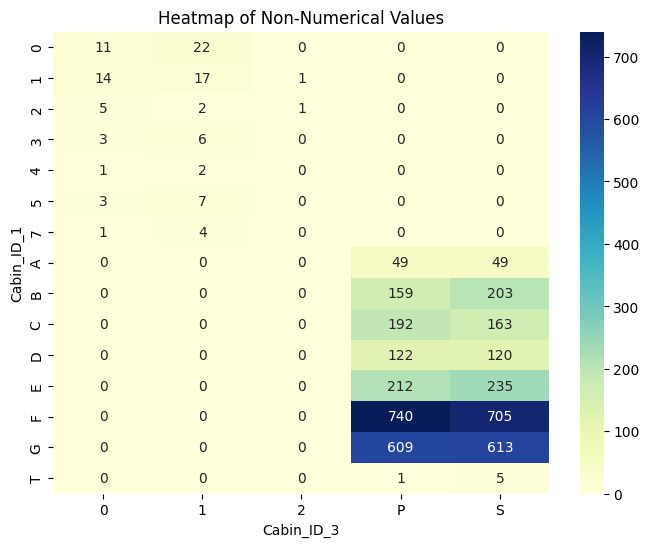

15 5
['G' 'F' 'C' 'B' 'D' 'E' 1 'A' 0 4 'T' 3 2 7 5] ['S' 'P' 0 1 2]


In [5]:
# Create a count of each combination
counts = training_data.groupby(['Cabin_ID_1', 'Cabin_ID_3']).size().unstack(fill_value=0)

# Create the heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(counts, annot=True, cmap="YlGnBu", fmt='d')
plt.title('Heatmap of Non-Numerical Values')
plt.xlabel('Cabin_ID_3')
plt.ylabel('Cabin_ID_1')
plt.show()

# Check cardinality
print(training_data['Cabin_ID_1'].nunique(), training_data['Cabin_ID_3'].nunique())
print(training_data['Cabin_ID_1'].unique(), training_data['Cabin_ID_3'].unique())


There are some interesting results, so I'll keep the plot here.

Given the cardinalities are low (and I want to train the NN and check accuracy), 
I'll just replace each category with a small integer, and improve on it later if necessary.

In [6]:
# Turn Cabin_ID_1, Cabin_ID_3 into their respective labels
training_data['Cabin_ID_1'] = training_data['Cabin_ID_1'].astype('category').cat.codes
training_data['Cabin_ID_3'] = training_data['Cabin_ID_3'].astype('category').cat.codes

### Finally, turning Passenger IDs into numbers
I see that there might be a correlation between Passenger IDs and Cabin IDs (which would make sense if, say, people booked together and were placed in the same cabins). I want to check this, though:

In [7]:
# Extract number before '__' from first column
training_data['deck_num'] = training_data['PassengerId'].astype(str).str.extract(r'^(\d+)').astype(float)

# Concatenate all three columns into a single string
training_data['cabin_combo'] = training_data[['Cabin_ID_1', 'Cabin_ID_2', 'Cabin_ID_3']].astype(str).agg('-'.join, axis=1)

# Correlation
is_unique = training_data.groupby('cabin_combo')['deck_num'].nunique() == 1
print(f"{is_unique.mean()*100:.2f}% of combos map to exactly one deck_num")

training_data = training_data.drop(['deck_num','cabin_combo'],axis=1)

100.00% of combos map to exactly one deck_num


This tells us that CabinIDs are almost entirely determined by PassengerIDs which share the suffix before '__'.
I'll just split them into `GroupId`, and then a "within-group" index (as `GroupRank`)



In [8]:
# Split PassengerIDs into groups and "within-group" ranks 
training_data['GroupId']   = training_data['PassengerId'].str.split('_').str[0]
training_data['GroupRank'] = training_data['PassengerId'].str.split('_').str[1].astype(int)

# Derive a "group size" feature instead of keeping an arbitrary ID
training_data['GroupSize'] = training_data.groupby('GroupId')['GroupId'].transform('count')

# Derive a "traveling alone" feature
training_data['IsAlone'] = (training_data['GroupSize'] == 1).astype(int)

# Drop the original PassengerId column and the GroupId
training_data = training_data.drop(['PassengerId','GroupId'],axis=1)

### Done! Let's save the processed training data

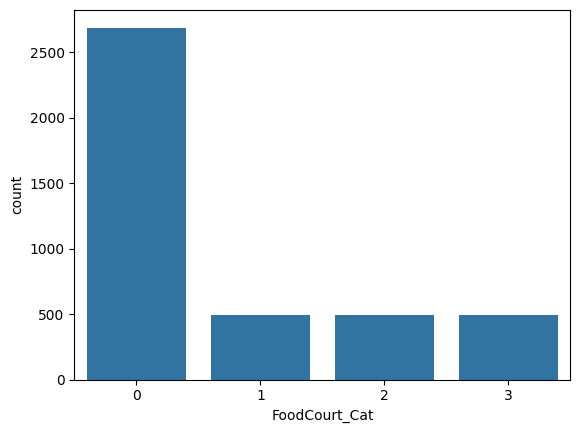

In [9]:
spending_categories = ['RoomService','FoodCourt','ShoppingMall','Spa','VRDeck']

for spending_cat in spending_categories:
    s = training_data[spending_cat]
    is_zero = s == 0
    cat = pd.Series(index=s.index, dtype="Int64")
    cat[is_zero] = 0
    nonzero = s[~is_zero]
    cat[~is_zero] = pd.qcut(nonzero, q=3, labels=[1,2,3], duplicates='drop')
    training_data[spending_cat+'_Cat'] = cat


sns.countplot(data=training_data, x='FoodCourt_Cat', order=[0,1,2,3])
plt.show()

# Drop the original spending categories
# training_data = training_data.drop(spending_categories,axis=1)

### NaNs...
I see that there are lots of missing values. Let's see where exactly:

In [10]:
print("NaNs per column:")
print(training_data.isna().sum())

NaNs per column:
HomePlanet           87
CryoSleep             0
Destination          92
Age                  91
VIP                   0
RoomService          82
FoodCourt           106
ShoppingMall         98
Spa                 101
VRDeck               80
Cabin_ID_1            0
Cabin_ID_2            0
Cabin_ID_3            0
GroupRank             0
GroupSize             0
IsAlone               0
RoomService_Cat      82
FoodCourt_Cat       106
ShoppingMall_Cat     98
Spa_Cat             101
VRDeck_Cat           80
dtype: int64


Just because I'm tired of fixing the data and really want to train the model right now, I'll just replace NaNs for their respective averages in each column :p

In [11]:
means = training_data.mean(numeric_only=True).round().astype('Int64')
training_data = training_data.fillna(means)

In [12]:
print("NaNs per column:")
print(training_data.isna().sum())

NaNs per column:
HomePlanet          0
CryoSleep           0
Destination         0
Age                 0
VIP                 0
RoomService         0
FoodCourt           0
ShoppingMall        0
Spa                 0
VRDeck              0
Cabin_ID_1          0
Cabin_ID_2          0
Cabin_ID_3          0
GroupRank           0
GroupSize           0
IsAlone             0
RoomService_Cat     0
FoodCourt_Cat       0
ShoppingMall_Cat    0
Spa_Cat             0
VRDeck_Cat          0
dtype: int64


No more invald values! Great. Let's scale the columns, reorganize them, and export the final training data.

In [13]:
# Before that, let's group essential and non-essential categories together
def avg_nonzero(cols):
    def compute(row):
        values = [row[col] for col in cols if row[col] > 0]
        return sum(values) / len(values) if values else 0
    return compute

essential = ["FoodCourt_Cat"]
non_essential = ["RoomService_Cat", "ShoppingMall_Cat", "Spa_Cat", "VRDeck_Cat"]

training_data["EssentialSpendingCat"] = training_data.apply(avg_nonzero(essential), axis=1).round().astype(int)
training_data["NonEssentialSpendingCat"] = training_data.apply(avg_nonzero(non_essential), axis=1).round().astype(int)

# training_data = training_data.drop(essential+non_essential, axis=1)


In [14]:
# Get the "Transported" column to the end of the df
if IS_TRAIN:
    col = training_data.pop("Transported")
    training_data["Transported"] = col

# Save processed training data in a new CSV
training_data.to_csv(base_file_path+('train' if IS_TRAIN else 'test')+'_processed.csv', index=False)

print(training_data)

      HomePlanet  CryoSleep  Destination   Age  VIP  RoomService  FoodCourt  \
0            0.0          1          0.0  27.0    0          0.0        0.0   
1            0.0          0          0.0  19.0    0          0.0        9.0   
2            1.0          1          1.0  31.0    0          0.0        0.0   
3            1.0          0          0.0  38.0    0          0.0     6652.0   
4            0.0          0          0.0  20.0    0         10.0        0.0   
...          ...        ...          ...   ...  ...          ...        ...   
4272         0.0          1          0.0  34.0    0          0.0        0.0   
4273         0.0          0          0.0  42.0    0          0.0      847.0   
4274         2.0          1          1.0  29.0    0          0.0        0.0   
4275         1.0          0          0.0  29.0    0          0.0     2680.0   
4276         0.0          1          2.0  43.0    0          0.0        0.0   

      ShoppingMall     Spa  VRDeck  ...  GroupRank 

### TODO
- ~~Replacing cabin_1, cabin_3 for numerical data~~
- ~~Turning Passenger IDs into numbers~~
- Turn Cabin IDs into more relevant stuff, do some feature eng
- ~~Turn RoomService,FoodCourt,ShoppingMall,Spa,VRDeck into spending categories (maybe with percentiles?) instead of numbers~~ 
- Group non-essential and essential spending categories together